# Emojify! 

* Create an embedding layer in Keras with pre-trained word vectors
* Build a sentiment classifier using word embeddings
* Build and train a more sophisticated classifier using an LSTM

In [17]:
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt
from test_utils import *

%matplotlib inline

In [18]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [19]:
maxLen = len(max(X_train, key=len).split())

In [20]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


### Emojifier-V1

In [21]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [22]:
idx = 50
print(f"Sentence '{X_train[50]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I missed you' has label index 0, which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0.]


#### Implementing
Convert each word in the input sentence into their word vector representations using pre-trained 50-dimensional GloVe embeddings.

In [23]:
with open("data/glove.6B.50d.txt", "r",encoding="utf-8") as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
        line = line.strip().split()
        curr_word = line[0]
        words.add(curr_word)
        word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

    i = 1
    word_to_index = {}
    index_to_word = {}
    for w in sorted(words):
        word_to_index[w] = i
        index_to_word[i] = w
        i = i + 1

In [24]:
word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


####  Sentence to Average
Take an average of the word vectors. 

In [25]:
def sentence_to_avg(sentence, word_to_vec_map):
    # Get a valid word contained in the word_to_vec_map. 
    any_word = list(word_to_vec_map.keys())[0]
    
    # Split sentence into list of lower case words
    words = sentence.lower().split()

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros(word_to_vec_map['a'].shape)
    
    # Initialize count to 0
    count = 0
    
    for w in words:                    # average the word vectors by looping over the words in the list "words".
        if w in word_to_vec_map:       # Check that word exists in word_to_vec_map
            avg += word_to_vec_map[w]
            count +=1    # Increment count
          
    if count > 0:        # Get the average. But only if count > 0
        avg = avg / count
        
    return avg

#### Implement the Model

* Pass the average through forward propagation
* Compute the cost
* Backpropagate to update the softmax parameters   

(The variable $Y_{oh}$ ("Y one hot") is the one-hot encoding of the output labels)

$$ z^{(i)} = Wavg^{(i)} + b$$

$$ a^{(i)} = softmax(z^{(i)})$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)$$

In [27]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    # Get a valid word contained in the word_to_vec_map 
    any_word = list(word_to_vec_map.keys())[0]
        
    # Initialize cost. It is needed during grading
    cost = 0
    
    # Define number of training examples
    m = Y.shape[0]                             # number of training examples
    n_y = len(np.unique(Y))                    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0]   # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
            
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer. 
            z = np.dot(W, avg) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = np.sum(Y_oh * np.log(a))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)   #predict is defined in emo_utils.py

    return pred, W, b

In [29]:
np.random.seed(1)
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = -227.52718163332128
Accuracy: 0.3484848484848485
Epoch: 100 --- cost = -418.19864120233854
Accuracy: 0.9318181818181818
Epoch: 200 --- cost = -482.7272770950607
Accuracy: 0.9545454545454546
Epoch: 300 --- cost = -516.6590639612793
Accuracy: 0.9696969696969697
[[3.]
 [2.]
 [3.]
 [0.]
 [4.]
 [0.]
 [3.]
 [2.]
 [3.]
 [1.]
 [3.]
 [3.]
 [1.]
 [3.]
 [2.]
 [3.]
 [2.]
 [3.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [1.]
 [4.]
 [3.]
 [3.]
 [4.]
 [0.]
 [3.]
 [4.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [3.]
 [4.]
 [2.]
 [2.]
 [0.]
 [2.]
 [3.]
 [0.]
 [3.]
 [2.]
 [4.]
 [3.]
 [0.]
 [3.]
 [3.]
 [3.]
 [4.]
 [2.]
 [1.]
 [1.]
 [1.]
 [2.]
 [3.]
 [1.]
 [0.]
 [0.]
 [0.]
 [3.]
 [4.]
 [4.]
 [2.]
 [2.]
 [1.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [0.]
 [3.]
 [3.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [4.]
 [3.]
 [3.]
 [2.]
 [4.]
 [0.]
 [0.]
 [3.]
 [3.]
 [3.]
 [3.]
 [2.]
 [0.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [3.]
 [2.]
 [2.]
 [2.]
 [4.]
 [1.]
 [1.]
 [3.]
 [3.]
 [4.]
 [1.]
 [2.]
 [1.]
 [1.]
 [3.]
 [1.]


#### Examining Test Set Performance 

In [30]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9772727272727273
Test set:
Accuracy: 0.8571428571428571


In [31]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


#### Confusion Matrix
A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class).

(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


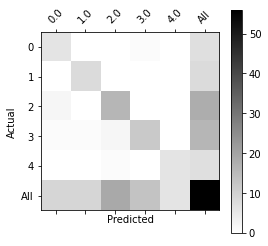

In [32]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

### Emojifier-V2: Using LSTMs in Keras 

building an LSTM model that takes word sequences as input. 
The model we'll implement consists of stacking 2 LSTM layers with a dropout layer in between and a dropout layers before our softmax.

In [33]:
import numpy as np
import tensorflow
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)

We will train Keras using mini-batches. For sequences to have same lenght we'll use padding.
The embedding layer takes an integer matrix input(converted from sentences to list of indices) and outputs a matrix with integers converted into embeddings.

#### Prepare the Input Sentences (sentences_to_indices)

This function processes an array of sentences X and returns inputs to the embedding layer:

* Convert each training sentences into a list of indices (the indices correspond to each word in the sentence)
* Zero-pad all these lists so that their length is the length of the longest sentence.

In [35]:
def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]                                   # number of training examples

    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        # Convert the ith training sentence in lower case and split is into words
        sentence_words = X[i].lower().split()
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index:
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                j =  j + 1

    return X_indices

In [37]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


#### Build Embedding Layer

* The embedding layer takes as input a list of word indices (sentences_to_indices() creates these word indices)
* The embedding layer will return the word embeddings for a sentence. 

In [38]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_size = len(word_to_index) + 1             # adding 1 to fit Keras embedding
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros((vocab_size, emb_dim))
    
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct input and output sizes (non-trainable)
    embedding_layer = Embedding(vocab_size, emb_dim, trainable = False)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [40]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim",embedding_layer.output_dim)

weights[0][1][1] = 0.39031
Input_dim 400001
Output_dim 50


#### Building the Emojifier-V2
feeding the embedding layer's output to an LSTM network!

In [41]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    # Define sentence_indices as the input of the graph.
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units = 128, return_sequences = True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5)(X) 
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units = 128, return_sequences = False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5)(X)  
    # Propagate X through a Dense layer with 5 units
    X = Dense(units = 5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [43]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645 

#### Compile the Model 
compile it and define what loss, optimizer and metrics you want to use.

In [44]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Train the Model 

In [45]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

In [46]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
5/5 [==============================] - 6s 16ms/step - loss: 1.5917 - accuracy: 0.3182
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 1.5075 - accuracy: 0.3561
Epoch 3/50
5/5 [==============================] - 0s 6ms/step - loss: 1.4304 - accuracy: 0.4394
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 1.3727 - accuracy: 0.4167
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 1.2787 - accuracy: 0.5682
Epoch 6/50
5/5 [==============================] - 0s 8ms/step - loss: 1.1725 - accuracy: 0.6288
Epoch 7/50
5/5 [==============================] - 0s 7ms/step - loss: 1.0214 - accuracy: 0.6667
Epoch 8/50
5/5 [==============================] - 0s 7ms/step - loss: 0.8687 - accuracy: 0.6894
Epoch 9/50
5/5 [==============================] - 0s 7ms/step - loss: 0.6786 - accuracy: 0.7727
Epoch 10/50
5/5 [==============================] - 0s 6ms/step - loss: 0.6090 - accuracy: 0.8030
Epoch 11/50
5/5 [=====================

In [47]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 1s 4ms/step - loss: 0.5718 - accuracy: 0.8036

Test accuracy =  0.8035714030265808


#### Print mislabelled examples

In [48]:
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:😞 prediction: work is horrible	😄
Expected emoji:🍴 prediction: any suggestions for dinner	😄
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😞 prediction: she is a bully	❤️
Expected emoji:😄 prediction: will you be my valentine	❤️
Expected emoji:❤️ prediction: I love you to the stars and back	😄
Expected emoji:😞 prediction: go away	⚾
Expected emoji:❤️ prediction: family is all I have	🍴


In [49]:
x_test = np.array(['not feeling happy'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

not feeling happy 😞
